In [37]:
from pytorch_grad_cam import ScoreCAM, GradCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import yaml
from torch.utils.data import DataLoader

In [2]:
labels = [(val, key) for key, val in {
    0:"Aerosol", 
    1:"Alcohol", 
    2:"Awl",
    3:"Axe", 
    4:"Bat",
    5:"Battery", 
    6:"Bullet", 
    7:"Firecracker", 
    8:"Gun", 
    9:"GunParts",
    10:"Hammer", 
    11:"HandCuffs", 
    12:"HDD", 
    13:"Knife",
    14:"Laptop",
    15:"Lighter",
    16:"Liquid", 
    17:"Match",
    18:"MetalPipe", 
    19:"NailClippers", 
    20:"PrtableGas", 
    21:"Saw", 
    22:"Scissors", 
    23:"Screwdriver", 
    24:"SmartPhone", 
    25:"SolidFuel", 
    26:"Spanner", 
    27:"SSD",
    28:"SupplymentaryBattery", 
    29:"TabletPC",
    30:"Thinner", 
    31:"USB",
    32:"ZippoOil", 
    33:"Plier", 
    34:"Chisel", 
    35:"Electronic cigarettes", 
    36:"Electronic cigarettes(Liquid)", 
    37:"Throwing Knife", 
}.items()]

labels = dict(labels)

In [3]:
with open('/opt/ml/finalproject/multilabel/Q2L/configs/train.yaml') as f:
        config_train = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
from dataset import CustomDataLoader, train_transform
import albumentations as A
train_dataset = CustomDataLoader(
        data_dir=config_train['train_path'], 
        mode="train", 
        transform= train_transform
    )


# data_loader
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=config_train['batch_size'],
    num_workers=config_train['workers'],
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!


In [5]:
first_batch = next(iter(train_loader))
print(first_batch[0][0, :, :, :].shape)
print(first_batch)

torch.Size([3, 384, 384])
[tensor([[[[-2.4808, -2.4807, -2.4808,  ..., -2.4807, -2.4808, -2.4808],
          [-2.4807, -2.4807, -2.4808,  ..., -2.4807, -2.4807, -2.4807],
          [-2.4808, -2.4807, -2.4808,  ..., -2.4807, -2.4807, -2.4808],
          ...,
          [-2.4807, -2.4807, -2.4807,  ..., -2.4807, -2.4807, -2.4808],
          [-2.4808, -2.4807, -2.4807,  ..., -2.4808, -2.4807, -2.4807],
          [-2.4808, -2.4807, -2.4808,  ..., -2.4808, -2.4808, -2.4808]],

         [[-2.4807, -2.4808, -2.4807,  ..., -2.4807, -2.4808, -2.4807],
          [-2.4807, -2.4807, -2.4807,  ..., -2.4807, -2.4807, -2.4807],
          [-2.4807, -2.4807, -2.4807,  ..., -2.4807, -2.4807, -2.4807],
          ...,
          [-2.4807, -2.4808, -2.4808,  ..., -2.4807, -2.4807, -2.4808],
          [-2.4807, -2.4807, -2.4808,  ..., -2.4808, -2.4808, -2.4808],
          [-2.4807, -2.4807, -2.4807,  ..., -2.4808, -2.4808, -2.4807]],

         [[-2.4808, -2.4808, -2.4808,  ..., -2.4808, -2.4807, -2.4808],
   

In [91]:
from torchvision.models import resnet101
from model import ResNet101
import torch

model = ResNet101(38)
checkpoint = torch.load('/opt/ml/runs/resnet101/best_95.85%.pth', map_location=torch.device('cuda'))
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [68]:
cam = EigenCAM(model,[model.backbone.layer4[-1]], use_cuda=True)

In [69]:

target_cat = labels['Lighter']
grayscale_cam = cam(input_tensor=first_batch[0][0, :, :, :].unsqueeze(0), target_category=6)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]

In [70]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

In [71]:
denorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
im_tensor = first_batch[0][0, :, :, :].clone()
img = denorm(im_tensor)
img2 = img.permute(1, 2, 0) * 255

In [72]:
visualization = show_cam_on_image(img2.numpy(), grayscale_cam, use_rgb=True)

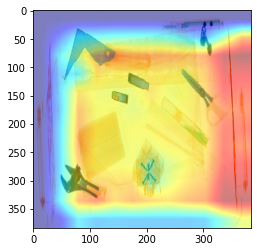

In [73]:
import matplotlib.pyplot as plt
plt.imshow(visualization)

In [26]:
out = model(first_batch[0][0, :, :, :].unsqueeze(0).to('cuda'))

In [84]:
first_batch[1][0]

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0.], dtype=torch.float64)

In [90]:
(out > 0.01).to(torch.float32)

tensor([[0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0.]], device='cuda:0')